# Poromechanical applications

**Recommended previous tutorials**:
- models_v2_ipynb

## Introduction
This tutorial shows how to set up and run poromechanical verifications.

We focus on two concrete cases:

- A non-linear poromechanical model using a manufactured solution.
- Mandel's consolidation problem based on the Biot equations of poroelasticity.

Other verifications can be run in a similar fashion.

## Case 1: Non-linear poromechanical model

Let us first import the mixer class `ManuPoroMechSetup`:

In [17]:
import porepy as pp

from tests.functional.setups.manu_poromech_nofrac import (
    ManuPoroMechSetup,
)

The next step consists in setting up the model parameters. For this
particular example, we set `material_constants` containing the values of the fluid
and solid physical constants, a `time_manager` object containing the time parameters,
and select as `manufactured_solution` the one employed in [1]. In
addition, we will use a mesh size of `0.075` and plot the results of the
verification.

In [18]:
# Set material constants
solid = pp.SolidConstants(
    {
        "biot_coefficient": 0.65,
        "lame_lambda": 1.5,
        "permeability": 0.3,
        "porosity": 0.15,
        "shear_modulus": 2.5,
    }
)
fluid = pp.FluidConstants(
    {
        "compressibility": 0.05,
        "density": 1.2,
        "viscosity": 0.75,
    }
)
material_constants = {"solid": solid, "fluid": fluid}

# Set mesh arguments
mesh_arguments = {"mesh_size_frac": 0.075, "mesh_size_bound": 0.075}

# Create time manager object. Constant time step size of 0.1.
time_manager = pp.TimeManager(
    schedule=[0, 1],
    dt_init=0.1,
    constant_dt=True
)

# Finally, create the params dictionary
params = {
    "manufactured_solution": "varela_2021",
    "material_constants": material_constants,
    "mesh_arguments": mesh_arguments,
    "time_manager": time_manager,
    "plot_results": True,
}

We are now in position to run the verification setup. To do this, we create an
instance of the `ManuPoroMechSetup` class,  passing the `params` dictionary to the
class constructor. We then use the `run_time_dependent_model()` method to run the model.

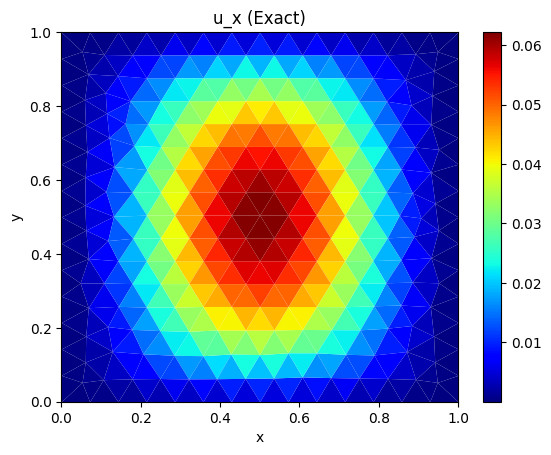

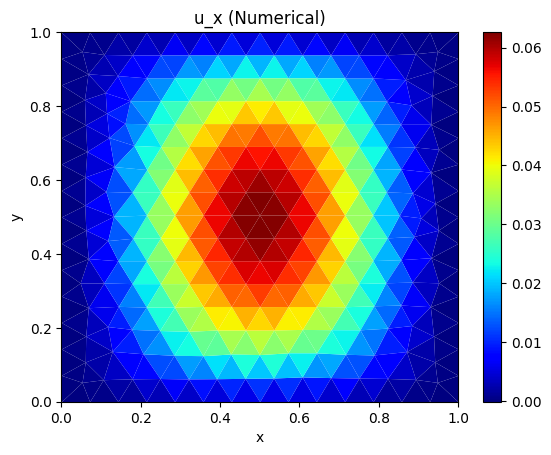

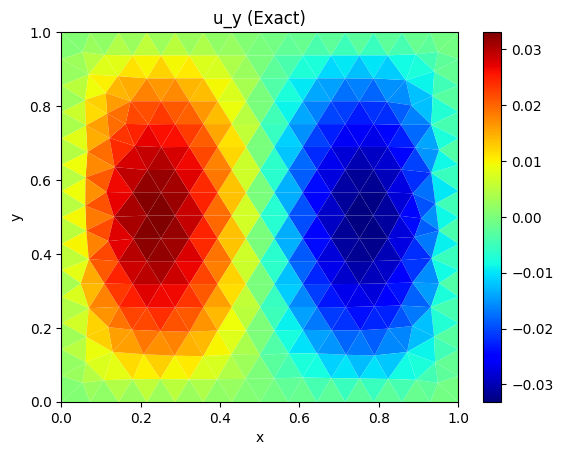

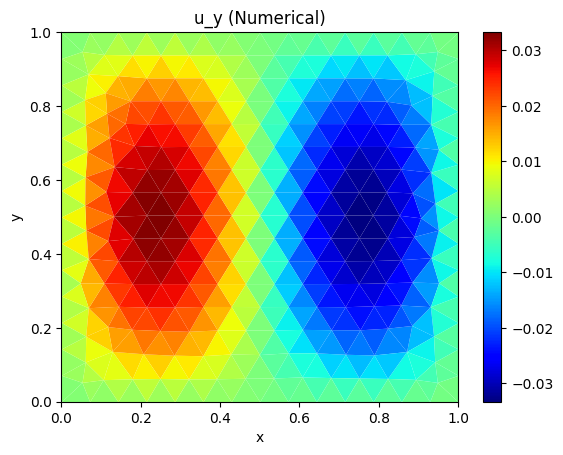

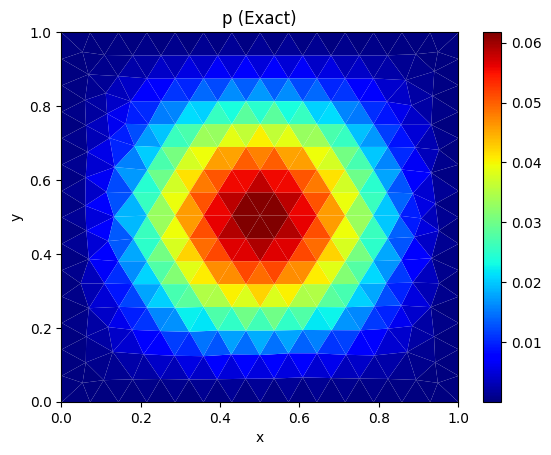

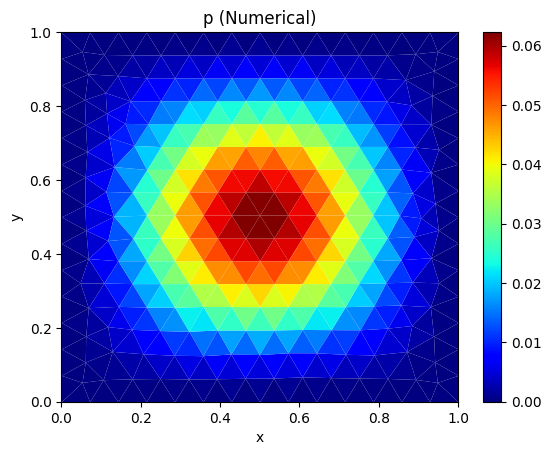

In [19]:
setup = ManuPoroMechSetup(params=params)
pp.run_time_dependent_model(model=setup, params=params)

The plots show the exact and numerical pressure and displacement fields for the final
simulation time. We can see by visual inspection of good level of agreement. However,
we can also measure the error using a discrete relative L2-norm such as the ones
defined in [2].

In [20]:
print(f"Pressure error: {setup.results[-1].error_pressure}.")
print(f"Displacement error: {setup.results[-1].error_displacement}.")

Pressure error: 0.008348855901570956.
Displacement error: 0.00875824255752228.


## Case 2: Mandel's problem

Let us now set up an example of Mandel's problem. Note that unlike the previous example
that considers a compressible fluid, Mandel's problem follows the Biot equations,
which is based on the assumption of slight fluid compressibility.

The mixer class for this verification is therefore based on the derived model class
`BiotPoromechanics` (see `porepy.applications.derived_models.biot`), a subclass of
the full poromechanical model `Poromechanics` (see `porepy.models.poromechanics`).

As in the previous example, let us first import the mixer class:

In [21]:
from porepy.applications.complete_setups.mandel_biot import MandelSetup

Now, it is simply a matter of setting up the model parameters. In this example, we
will use real physical parameters. For the user's convenience, the `mandel_biot.py`
module contains suggested physical constants for the fluid and the solid (the same
physical parameters employed in [3]).

Let's import them:

In [22]:
from porepy.applications.complete_setups.mandel_biot import (
    mandel_fluid_constants,
    mandel_solid_constants
)

and set the model parameters:

In [23]:
# Set material constants
material_constants = {
    "solid": pp.SolidConstants(mandel_solid_constants),
    "fluid": pp.FluidConstants(mandel_fluid_constants),
}

# Set scaling
scaling = {"m": 1e-3}
units = pp.Units(**scaling)

# Create time manager
time_manager = pp.TimeManager(
        schedule=[0, 2e1, 1e2, 1e3, 5e3, 1e4],
        dt_init=20,
        constant_dt=True,
)

# Set mesh size (only mesh_size_bound is used).
ls = 1 / units.m  # length scaling
mesh_arguments = {"mesh_size_frac": 5.0 * ls, "mesh_size_bound": 5.0 * ls}

# Create model params
params = {
    "material_constants": material_constants,
    "mesh_arguments": mesh_arguments,
    "time_manager": time_manager,
    "plot_results": True,
    "units": units,
}

Note that we introduced a length scaling via the `pp.Units` class, where we specify a
factor of `1e-3`, thus effectively measuring length in _millimeters_. Defining a
properly scaled problem can have positive consequences for the conditioning of the
linear system. Note that other base magnitudes can also be scaled analogously.

Finally, let's run the verification setup:

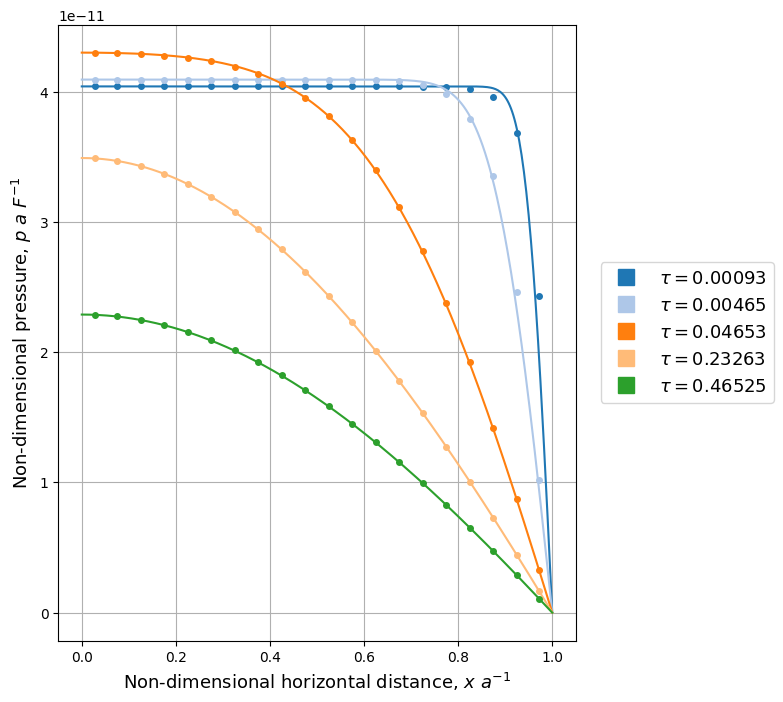

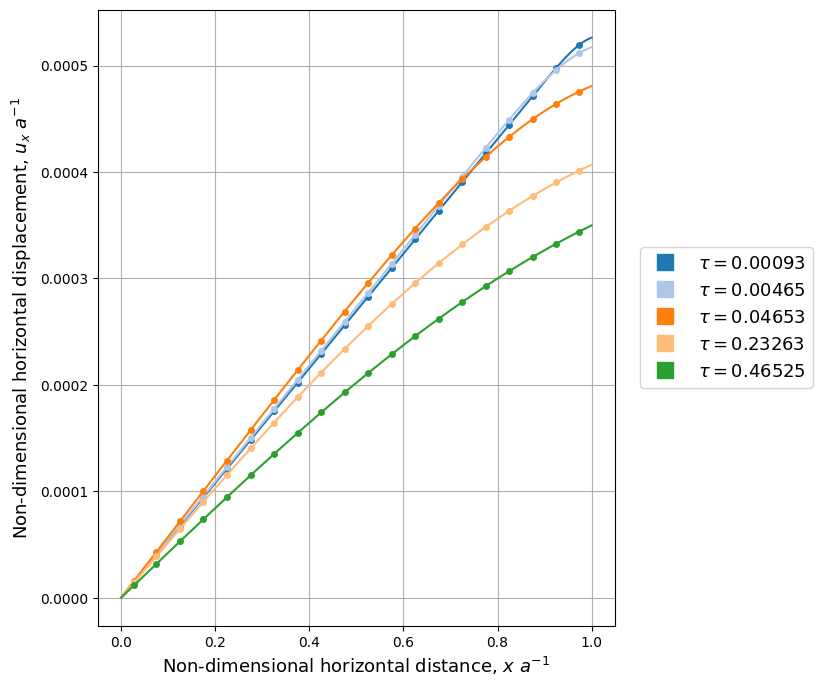

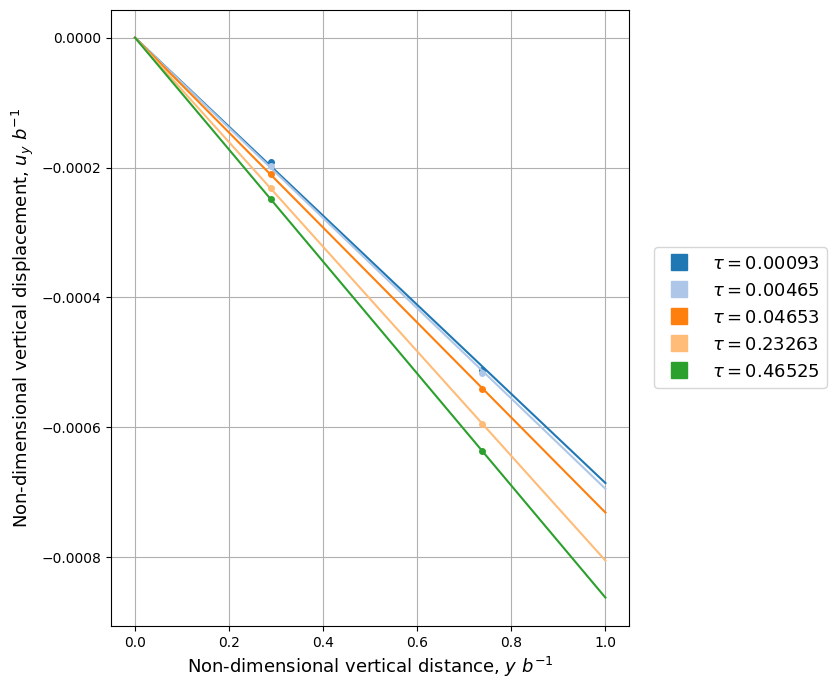

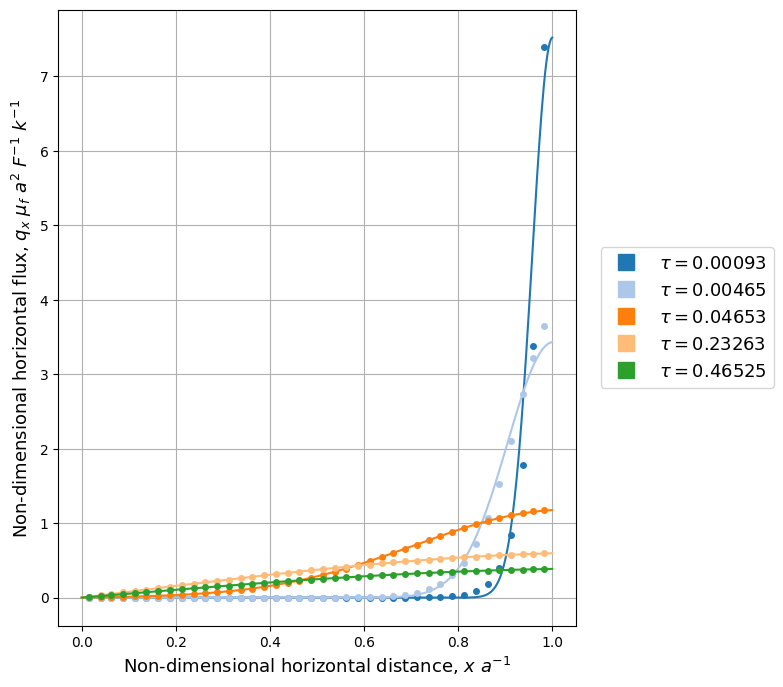

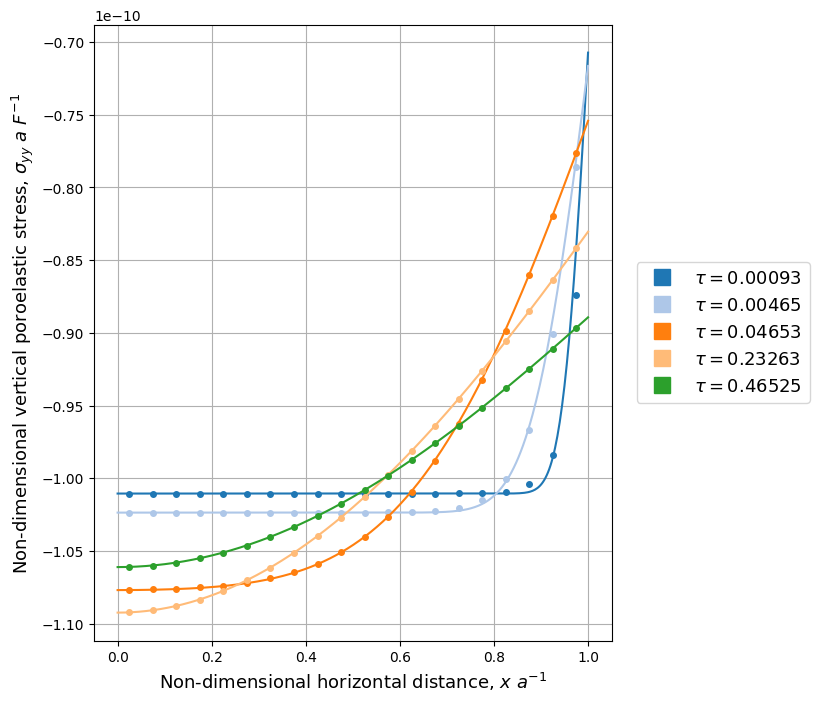

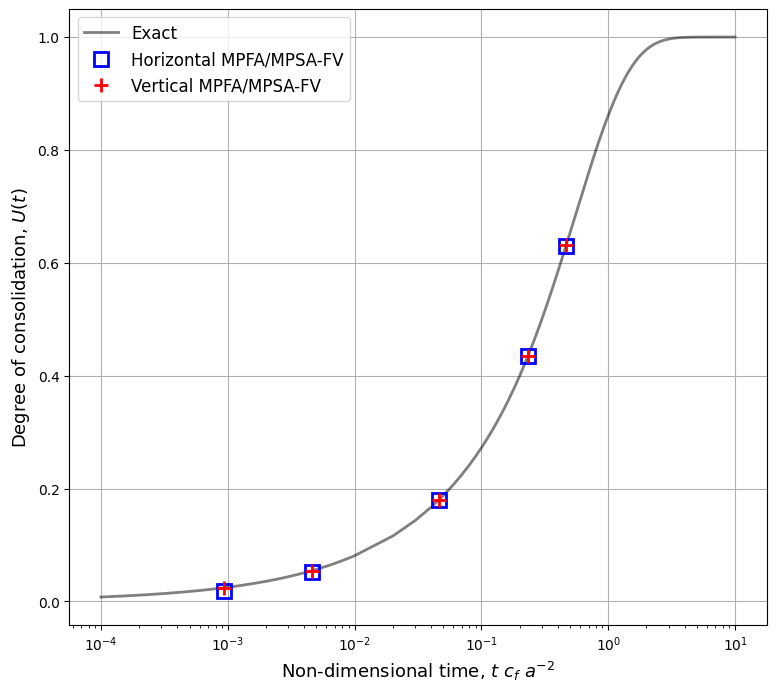

In [24]:
setup = MandelSetup(params=params)
pp.run_time_dependent_model(model=setup, params=params)

In the plots from above, the solid lines represent the exact solutions and the dots
the numerical approximations obtained with MPSA/MPFA-FV. Each line corresponds to a
scheduled time, with $\tau$ denoting the dimensionless time.

The last plot shows the degree of consolidation (a dimensionless quantity measuring
the state of consolidation of the soil) as a function of time.

## References

[1] Varela, J., Gasda, S. E., Keilegavlen, E., & Nordbotten, J. M. (2021). A
Finite-Volume-Based Module for Unsaturated Poroelasticity. Advanced Modeling with the
MATLAB Reservoir Simulation Toolbox.

[2] Nordbotten, J. M. (2016). Stable cell-centered finite volume discretization for Biot
equations. SIAM Journal on Numerical Analysis, 54(2), 942-968.

[3] Keilegavlen, E., Berge, R., Fumagalli, A., Starnoni, M., Stefansson, I., Varela, J.,
& Berre, I. (2021). Porepy: An open-source software for simulation of multiphysics
processes in fractured porous media. Computational Geosciences, 25, 243-265.

## What have we done?
We have shown how to set up and run poromechanical models using two verification
setups as examples.